In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist

import pydrake
from pydrake.all import (
    Quaternion,
    RotationMatrix,
    RollPitchYaw
)

from spatial_scene_grammars.rules import WorldFrameBinghamRotationRule
from spatial_scene_grammars.nodes import *

torch.set_default_tensor_type(torch.DoubleTensor)

Bingam Distribution for quaternions $q$:

- $M$ = 4x4 orthogonal orientation
- $Z$ = 4x4 diagonal concentration

$$p(q) = \dfrac{1}{C(Z)} e^{ \text{tr } Z M^T q q^T M}$$

In [29]:
dists = {
    "spread_1": BinghamDistribution(
        param_m=torch.eye(4),
        param_z=torch.tensor([-100, -100, -100, 0.])
    ),
    "tight_2": BinghamDistribution(
        param_m=torch.eye(4),
        param_z=torch.tensor([-1000, -10, -10, 0.])
    ),
    "tight": BinghamDistribution(
        param_m=torch.eye(4),
        param_z=torch.tensor([-1000, -1000, -1000, 0.])
    ),
}
dists = {}
dists["Mean +x, Uncertain in Z"] = WorldFrameBinghamRotationRule.from_rotation_and_rpy_variances(
    RotationMatrix(rpy=RollPitchYaw([0., 0., 0.])), [100, 100, 1]
)._bingham_dist
dists["Mean +z, Tight"] = WorldFrameBinghamRotationRule.from_rotation_and_rpy_variances(
    RotationMatrix(rpy=RollPitchYaw([0., -np.pi/2., 0.])), [50, 50, 50]
)._bingham_dist

datas = {}
for name, dist in dists.items():
    datas[name] = dist.sample(sample_shape=(500,))
    print(RollPitchYaw(Quaternion(datas[name][-1])).vector())

[ 0.2012247  -0.18264332 -0.43799296]
[-2.40050097 -1.31080323  2.4899911 ]


<IPython.core.display.Javascript object>


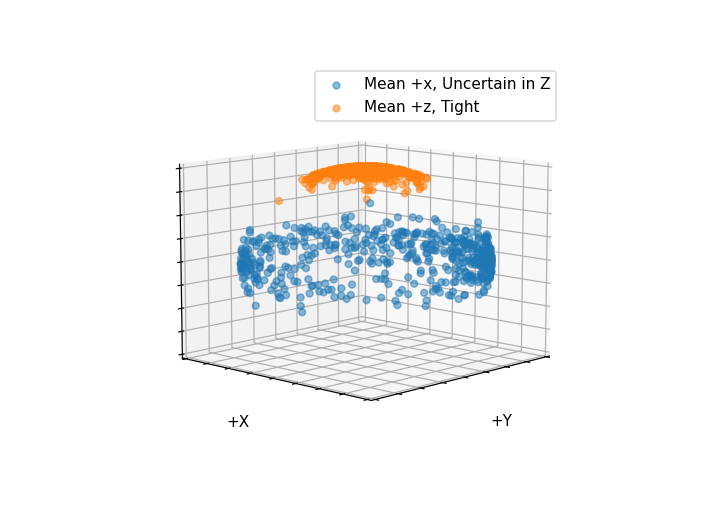

In [30]:
%matplotlib notebook

def draw_data(name, data, ax):
    # Rotate +x by data to get a view into these points on the 3D sphere
    tfd_vecs = []
    vec = np.array([1., 0., 0.])
    for q in data:
        tfd_vecs.append(RotationMatrix(quaternion=Quaternion(q)).multiply(vec))
    tfd_vecs = np.stack(tfd_vecs)

    ax.scatter(tfd_vecs[:, 0], tfd_vecs[:, 1], tfd_vecs[:, 2], label=name, alpha=0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for name, data in datas.items():
    draw_data(name, data, ax)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.xlabel("+Y")
ax.set_xticklabels([])
plt.ylabel("+X")
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.legend()
plt.show()

In [34]:
%matplotlib notebook

# For a test dataset, ensure we recover the original if we do a fit
test_dist = WorldFrameBinghamRotationRule.from_rotation_and_rpy_variances(
    RotationMatrix(rpy=RollPitchYaw([0., 0., np.pi/2.])), [10, 50, 100]
)._bingham_dist
samples = test_dist.sample(sample_shape=(2500,))
weights = torch.rand(samples.shape[0])
new_m, new_z = BinghamDistribution.fit(samples, weights)
print("Target M: ", test_dist.m)
print("Fit M: ", new_m)
print("M fit absolute error: ", torch.abs(test_dist.m - new_m))
print("Mode absolute error: ", torch.abs(test_dist.m[:, -1] - new_m[:, -1]))
print("Z fit relative error: ", torch.abs(test_dist.z - new_z)/torch.abs(test_dist.z+1E-6))

# Looks basically like it's working, down to sign flips in columns of M.

Target M:  tensor([[-7.0711e-01,  4.3298e-17,  4.3298e-17,  7.0711e-01],
        [ 0.0000e+00,  7.0711e-01,  7.0711e-01,  0.0000e+00],
        [ 0.0000e+00,  7.0711e-01, -7.0711e-01,  0.0000e+00],
        [ 7.0711e-01,  4.3298e-17,  4.3298e-17,  7.0711e-01]])
Fit M:  tensor([[-0.7064, -0.0239,  0.0084, -0.7073],
        [-0.0237,  0.7170,  0.6966,  0.0077],
        [-0.0245,  0.6962, -0.7174, -0.0076],
        [ 0.7069,  0.0243,  0.0069, -0.7068]])
M fit absolute error:  tensor([[6.6268e-04, 2.3906e-02, 8.4433e-03, 1.4144e+00],
        [2.3653e-02, 9.9192e-03, 1.0504e-02, 7.7055e-03],
        [2.4524e-02, 1.0893e-02, 1.0268e-02, 7.6005e-03],
        [1.5852e-04, 2.4253e-02, 6.8590e-03, 1.4139e+00]])
Mode absolute error:  tensor([1.4144, 0.0077, 0.0076, 1.4139])
Z fit relative error:  tensor([0.0008, 0.0027, 0.0287, 0.0000])


# Test node sampling + parsing + parameter est

<IPython.core.display.Javascript object>


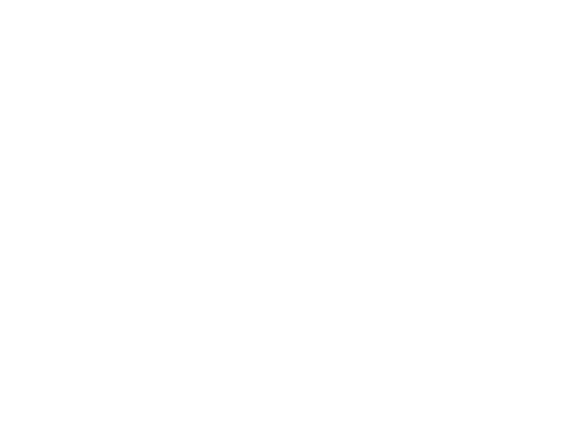

In [4]:
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.parameter_estimation import *
from tqdm.notebook import tqdm

# Define a trivial grammar to flex the bingham rule in an
# unobserved way

class Observed(TerminalNode):
    def __init__(self, tf):
        super().__init__(observed=True, physics_geometry_info=None, tf=tf)

class Intermediate(AndNode):
    def __init__(self, tf):
        super().__init__(observed=False, physics_geometry_info=None, tf=tf)
    @classmethod
    def generate_rules(cls):
        return [
            ProductionRule(
                child_type=Observed,
                xyz_rule=SamePositionRule(),
                rotation_rule=SameRotationRule()
            )
        ]
class Root(AndNode):
    def __init__(self, tf):
        super().__init__(observed=True, physics_geometry_info=None, tf=tf)
    @classmethod
    def generate_rules(cls):
        return [
            ProductionRule(
                child_type=Intermediate,
                xyz_rule=SamePositionRule(),
                rotation_rule=WorldFrameBinghamRotationRule.from_rotation_and_rpy_variances(
                    RotationMatrix(RollPitchYaw([0., -np.pi/4., 0.])),
                    [100., 100., 1.]
                )
            )
        ]

grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

trees = [grammar.sample_tree(detach=True) for k in range(100)]
observed_node_sets = [tree.get_observed_nodes() for tree in trees]

def scatter_px_dirs(tree_set, node_type):
    tfd_vecs = []
    vec = np.array([1., 0., 0.])
    for tree in tree_set:
        for node in tree.find_nodes_by_type(node_type):
            tfd_vecs.append(RotationMatrix(node.rotation.detach().numpy()).multiply(vec))
    tfd_vecs = np.stack(tfd_vecs)
    
    ax.scatter(tfd_vecs[:, 0], tfd_vecs[:, 1], tfd_vecs[:, 2], label=node_type.__name__, alpha=0.5)
    
# Do similar scatterplot of rotated +x vector of frame of interest
# to get a sense of rotate distribution.
scatter_px_dirs(trees, Intermediate)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scatter_px_dirs(trees, Intermediate)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.xlabel("+Y")
plt.ylabel("+X")
plt.legend()
plt.show()

In [36]:
# Try to do parameter estimation on these environments. It should be trivial
# to parse, since the intermediate position = the child positions.
fit_grammar = grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.])),
    sample_params_from_prior=True
)
em = EMWrapper(fit_grammar, observed_node_sets)
em.do_iterated_em_fitting(em_iterations=2, tqdm=tqdm, num_workers=1)

EM Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (Intermediate): None
    (Observed): None
    (Root): None
  )
  (rule_params_by_node_type): ModuleDict(
    (Intermediate): ModuleList(
      (0): ModuleList(
        (0): ModuleDict()
        (1): ModuleDict()
      )
    )
    (Observed): ModuleList()
    (Root): ModuleList(
      (0): ModuleList(
        (0): ModuleDict()
        (1): ModuleDict(
          (M): ConstrainedParameter()
          (Z): ConstrainedParameter()
        )
      )
    )
  )
)

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:764: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


0:rot:M final: tensor([[ 0.2095,  0.3287,  0.1215,  0.9129],
        [-0.7818,  0.4813, -0.3921,  0.0583],
        [ 0.4794,  0.7863, -0.0483, -0.3867],
        [ 0.3392, -0.2051, -0.9106,  0.1172]])
0:rot:Z final: tensor([-97.0698, -78.8900,  -1.0008,   0.0000])
GT params:  ({}, {'M': tensor([[ 5.6571e-17,  3.8268e-01,  5.6571e-17,  9.2388e-01],
        [ 9.2388e-01,  0.0000e+00,  3.8268e-01,  0.0000e+00],
        [-2.3433e-17,  9.2388e-01, -2.3433e-17, -3.8268e-01],
        [-3.8268e-01,  0.0000e+00,  9.2388e-01,  0.0000e+00]]), 'Z': tensor([-100., -100.,   -1.,    0.])})


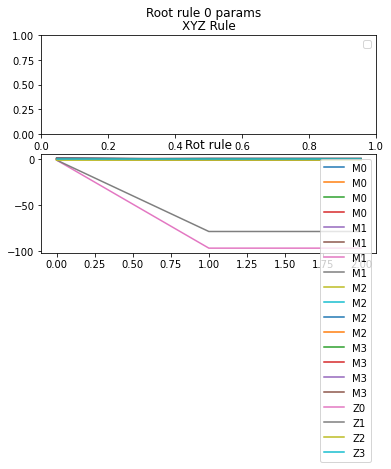

In [45]:
%matplotlib inline
em.plot_grammar_parameter_history(Root)
print("GT params: ", trees[0].find_nodes_by_type(Root)[0].rules[0].parameters)

# Checking that parsing is doing the right thing

In [ ]:
# Need a slightly harder grammar to flex parsing: need intermediate rotation
# to be unconstrained relative to child and parent.
# In this grammar, since child rotation is independent of intermediate
# rotation, the optimal parse should put the intermediate rotation at
# the mode of the Root's rotation rule.

class Observed(TerminalNode):
    def __init__(self, tf):
        super().__init__(observed=True, physics_geometry_info=None, tf=tf)

class Intermediate(AndNode):
    def __init__(self, tf):
        super().__init__(observed=False, physics_geometry_info=None, tf=tf)
    @classmethod
    def generate_rules(cls):
        return [
            ProductionRule(
                child_type=Observed,
                xyz_rule=SamePositionRule(),
                rotation_rule=WorldFrameBinghamRotationRule.from_rotation_and_rpy_variances(
                    RotationMatrix(RollPitchYaw([0., 0., 0.])),
                    [1., 1., 1.]
                )
            )
        ]
    
gt_intermediate_rot_mode = RotationMatrix(RollPitchYaw([1., 1., 2.]))
rule = WorldFrameBinghamRotationRule.from_rotation_and_rpy_variances(
    gt_intermediate_rot_mode,
    [100., 105., 100.]
)
class Root(AndNode):
    def __init__(self, tf):
        super().__init__(observed=True, physics_geometry_info=None, tf=tf)
    @classmethod
    def generate_rules(cls):
        return [
            ProductionRule(
                child_type=Intermediate,
                xyz_rule=SamePositionRule(),
                rotation_rule=rule
            )
        ]

grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform())
)

tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

print(tree.find_nodes_by_type(Root)[0].rules[0].parameters)
print(tree.find_nodes_by_type(Root)[0].rules[0])

# Parse an observation; it'll have multiple optimal parses due to
# integer variables available in the tree.
trees = get_optimized_trees_from_mip_results(infer_mle_tree_with_mip(grammar, observed_nodes, N_solutions=10))
for tree in trees:
    optimized_tree = optimize_scene_tree_with_nlp(grammar, tree, initial_guess_tree=tree).refined_tree
    R = RotationMatrix(optimized_tree.find_nodes_by_type(Intermediate)[0].rotation.detach().numpy())
    R_diff = R.inverse().multiply(gt_intermediate_rot_mode)
    print("Geodesic from mode: ", np.arccos((np.trace(R_diff.matrix()) - 1.) / 2.))

In [ ]:
Z = np.diag([-100, -100, -100, 0])
M = np.array([[6.1232e-17, 6.1232e-17, 6.1232e-17, 1.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]])
q = np.array([[1., 0., 0., 0.]]).reshape(4, 1)
qqt = q.dot(q.T)
print(np.trace(Z.dot(M.T.dot(qqt.dot(M)))))